# Вариант 7. Толщина кожной складки всех студентов первого курса.

Данные из файла Volgmed_2013.xls (конкретные данные выбрать 
в соответствии с вариантом) очистить от выбросов и пропусков, 
аппроксимировать наилучшей смесью нормальных в соответствии с 
байесовским информационным критерием.

На основании асимптотического критерия отношения правдоподобия 
найти пи-значение смеси, в которой число нормальных компонент больше на 1, 
относительно наилучшей смеси.

Протестировать соответствие данных и наилучшей смеси 
по критерию Колмогорова—Смирнова: оценить параметры \
а) по первой половине наблюдений; \
б) по второй половине наблюдений; \
в) дважды по случайно выбранной половине наблюдений; \
вычислить пи-значения по оставшимся наблюдениям.

Вывести плотность распределения полученной аппроксимации вместе с гистограммой, 
а ее функцию распределения вместе с эмпирической функцией распределения.

In [1]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.mixture import GaussianMixture

warnings.filterwarnings("ignore")

N_MODELS = 3

In [2]:
filepath = Path("Volgmed_2013.xlsx")

df_input = pd.read_excel(filepath, index_col=1, header=1)
df_input.head()

,№ п/п,Год рождения,Факультет,Курс,Группа,Год поступления,Дата обследования,"Рост, см","Вес, кг","Окружность грудной клетки в покое, см",...,"Гибкость, см","Время 10 хлопков, с","Прыжок в длину с места, см","Челночный бег, с","Силовой норматив, ед","Бег 100 м, с","Бег 2-3 км, мин","Статическая выносливость, с","Задержка дыхания, с","Равновесие, с"
Пол,,,,,,,,,,,,,,,,,,,,,
жен,104.0,1981.0,лечебный,1.0,NaN,1999,2000-05-01,176,74.5,90,...,22,6.6,155,26,38,17.7,8.7,140,59.0,90.0
жен,104.0,1981.0,лечебный,3.0,NaN,1999,2002-05-01,176,74,90,...,23,6.5,158,25,47,18.7,6.58,144,68.0,90.0
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_input.columns

Index(['№ п/п', 'Год рождения', 'Факультет', 'Курс', 'Группа',
       'Год поступления', 'Дата обследования', 'Рост, см', 'Вес, кг',
       'Окружность грудной клетки в покое, см',
       'Окружность грудной клетки на вдохе, см',
       'Окружность грудной клетки на выдохе, см',
       'Экскурсия грудной клетки, см', 'Толщина кожной складки, мм',
       'Сила правой руки, кг', 'Сила левой руки, кг', 'Становая сила, кг',
       'Гибкость, см', 'Время 10 хлопков, с', 'Прыжок в длину с места, см',
       'Челночный бег, с', 'Силовой норматив, ед', 'Бег 100 м, с',
       'Бег 2-3 км, мин', 'Статическая  выносливость, с',
       'Задержка дыхания, с', 'Равновесие, с'],
      dtype='object')

In [4]:
data = df_input[df_input["Курс"] == 1]["Толщина кожной складки, мм"]
data.reset_index(drop=True, inplace=True)
data

0         16
1       11.5
2        8.5
3       13.5
4       14.5
        ... 
1045       9
1046       8
1047       7
1048       8
1049       6
Name: Толщина кожной складки, мм, Length: 1050, dtype: object

In [5]:
q1 = data.quantile(0.25)
q3 = data.quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = data[(data < lower_bound) | (data > upper_bound)]

data = data.drop(outliers.index).dropna()
data

0         16
1       11.5
2        8.5
3       13.5
4       14.5
        ... 
1045       9
1046       8
1047       7
1048       8
1049       6
Name: Толщина кожной складки, мм, Length: 998, dtype: object

Лучшее число компонент: 2


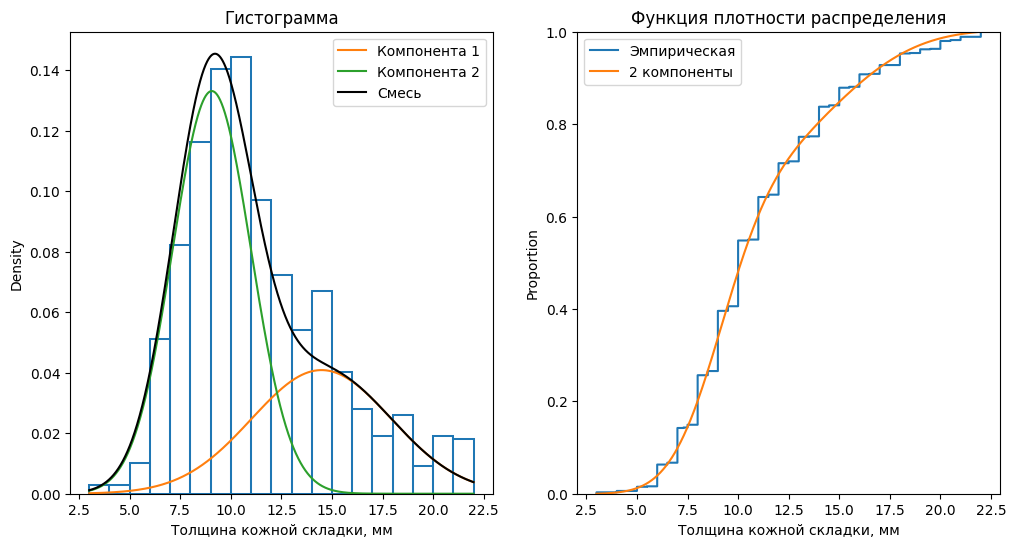

In [6]:
def get_gmm_params_amount(n_components: int) -> int:
    """Возвращает количество параметров в зависимости от количества компонент в смеси нормальных распределений"""
    assert n_components > 0, "n_components should be greater than 0"
    return 3 * n_components - 1


def bic(n_params: int, sample_size: int, log_likelihood: float) -> float:
    """Считает значение критерия BIC для модели

    Args:
        n_params: количество параметров в модели
        sample_size: размер выборки
        log_likelihood: значение логарифма правдоподобия

    Returns:
        Значение критерия BIC
    """
    return n_params * np.log(sample_size) - 2 * log_likelihood


def make_report(n_components: int, log_likelihood: float, bic: float) -> str:
    """Формирует отчет о модели"""
    report = f"Число компонент: {n_components},\nЛогарифм правдоподобия: {log_likelihood:.2f},\nBIC: {bic:.2f}.\n"
    return report


def plot_components(gmm: GaussianMixture, x: np.ndarray) -> None:
    """Строит графики компонент смеси"""
    means = gmm.means_.flatten()
    covs = gmm.covariances_.flatten()
    weights = gmm.weights_

    for i, (mean, cov, weight) in enumerate(zip(means, covs, weights), start=1):
        y = weight * stats.norm.pdf(x, mean, np.sqrt(cov))
        plt.plot(x, y, label=f"Компонента {i}")


models = []
for n_components in range(1, N_MODELS + 1):
    gmm = GaussianMixture(n_components, random_state=42)
    gmm.fit(data.values.reshape(-1, 1))

    gmm_n_params = get_gmm_params_amount(n_components)
    log_likelihood = gmm.score_samples(data.values.reshape(-1, 1)).sum()
    bic_value = bic(gmm_n_params, len(data), log_likelihood)

    models.append(
        {
            "model": gmm,
            "n_components": n_components,
            "n_params": gmm_n_params,
            "log_likelihood": log_likelihood,
            "bic": bic_value,
        }
    )

best_model = min(models, key=lambda x: x["bic"])
print(f"Лучшее число компонент: {best_model["n_components"]}")

x = np.linspace(data.min(), data.max(), 2000)
log_likelihoods = np.exp([best_model["model"].score_samples(e.reshape(-1, 1)) for e in x])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data, stat="density", fill=False).set_title("Гистограмма")
plot_components(best_model["model"], x)
plt.plot(x, log_likelihoods, color="black", label="Смесь")
plt.legend()

plt.subplot(1, 2, 2)
sns.ecdfplot(data, label="Эмпирическая").set_title(
    "Функция плотности распределения"
)
plt.plot(
    x,
    np.cumsum(log_likelihoods) / np.sum(log_likelihoods),
    label=f"{best_model["n_components"]} компоненты",
)
plt.legend()

plt.show()

In [7]:
def log_likelihood_ratio(ll_1: float, ll_2: float) -> float:
    """Считает отношение логарифмов правдоподобия"""
    return 2 * (ll_2 - ll_1)


n_components_best = best_model["n_components"]
next_model = models[n_components_best]

llr = log_likelihood_ratio(best_model["log_likelihood"], next_model["log_likelihood"])
param_diff = abs(best_model["n_params"] - next_model["n_params"])
p_value = stats.chi2.sf(llr, param_diff)

print(f"p-value смеси с числом компонент больше на 1: {p_value}")

p-value смеси с числом компонент больше на 1: 0.013293856596704933


In [8]:
def ks1_asympt(cdf_data):
    # Из лекции
    n = len(cdf_data)
    cdf_data.sort()
    D_n = 0
    for i in range(n):
        if max(abs(cdf_data[i] - i / n), abs(cdf_data[i] - (i - 1) / n)) > D_n:
            D_n = max(abs(cdf_data[i] - i / n), abs(cdf_data[i] - (i - 1) / n))
    return stats.kstwobign.sf(n**0.5 * D_n)


data_xuy = data.astype(float)
data_xuy.reset_index(drop=True, inplace=True)

In [9]:
data_1 = data_xuy[:round(len(data) / 2)]
data_2 = data_xuy[round(len(data) / 2):]
cdf_data = np.zeros(len(data_2))

best_model = min(models, key=lambda x: x["bic"])["model"]
for mu, sd, p in zip(
    best_model.means_.flatten(), best_model.covariances_.flatten(), best_model.weights_
):
    cdf_data += p * stats.norm(mu, sd).cdf(data_2)

print("{:.20f}".format(ks1_asympt(cdf_data)))

0.00000000000000000000


In [10]:
data_1 = data_xuy[round(len(data) / 2):]
data_2 = data_xuy[:round(len(data) / 2)]
cdf_data = np.zeros(len(data_2))

best_model = min(models, key=lambda x: x["bic"])["model"]
for mu, sd, p in zip(
    best_model.means_.flatten(), best_model.covariances_.flatten(), best_model.weights_
):
    cdf_data += p * stats.norm(mu, sd).cdf(data_2)

print("{:.20f}".format(ks1_asympt(cdf_data)))

0.00000000000000000000


In [11]:
np.random.shuffle(data_xuy)

In [12]:
data_1 = data_xuy[:round(len(data) / 2)]
data_2 = data_xuy[round(len(data) / 2):]
cdf_data = np.zeros(len(data_2))

best_model = min(models, key=lambda x: x["bic"])["model"]
for mu, sd, p in zip(
    best_model.means_.flatten(), best_model.covariances_.flatten(), best_model.weights_
):
    cdf_data += p * stats.norm(mu, sd).cdf(data_2)

print("{:.20f}".format(ks1_asympt(cdf_data)))

0.00000000000000000000


In [13]:
np.random.shuffle(data_xuy)

In [14]:
data_1 = data_xuy[round(len(data) / 2):]
data_2 = data_xuy[:round(len(data) / 2)]
cdf_data = np.zeros(len(data_2))

best_model = min(models, key=lambda x: x["bic"])["model"]
for mu, sd, p in zip(
    best_model.means_.flatten(), best_model.covariances_.flatten(), best_model.weights_
):
    cdf_data += p * stats.norm(mu, sd).cdf(data_2)

print("{:.20f}".format(ks1_asympt(cdf_data)))

0.00000000000000000001
